In [5]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time;  from datetime import datetime
import math
plt.rcParams["figure.figsize"] = (15,10)

In [28]:
mobile = pd.read_csv('mobile_bid_adjustments.csv') # read the mobile
# date range -> "June 1, 2017 - January 26, 2018"

summary = mobile.tail(2) # store summary rows separately
mobile = mobile.drop([327,328]) # drop summary columns rows
orig_mobile=pd.read_csv('mobile_bid_adjustments.csv') # read the mobile

In [29]:
mobile.rename(columns={'Avg. CPC':'avg_cpc($)'}, inplace=True)
mobile.rename(columns={'Cost / conv.':'cost_per_conv($)'}, inplace=True)
mobile.rename(columns={'Conv. rate':'conversion_rate(%)'}, inplace=True)
mobile.rename(columns={'Avg. CPC':'avg_cpc($)'}, inplace=True)
mobile.rename(columns={'Cost':'Cost($)'}, inplace=True)
mobile.rename(columns={'CTR':'CTR(%)'}, inplace=True)
mobile.rename(columns={'Conv. value':'Conv. value($)'}, inplace=True)
mobile.rename(columns={'Bid adj.':"Bid adj.(%)"}, inplace=True)

In [30]:
mobile.head()

,Location,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost
0,"Fremont, Ohio, United States",+60%,72,"1,108",6.50%,$0.43,$30.82,2.6,0.00,$0.00,0.00%,0.00,0.00
1,"32216, Florida, United States",+45%,51,857,5.95%,$0.43,$22.04,2.6,0.00,$0.00,0.00%,0.00,0.00
2,"Madera, California, United States",+60%,186,"2,187",8.50%,$0.46,$85.09,2.6,2.00,$42.55,1.08%,103.30,1.21
3,"Linden, Alabama, United States",+60%,3,79,3.80%,$0.31,$0.93,3.0,0.00,$0.00,0.00%,0.00,0.00
4,"60632, Illinois, United States",-90%,8,263,3.04%,$0.02,$0.19,3.7,0.00,$0.00,0.00%,0.00,0.00


In [31]:
### CONVERT DATA INTO FLOATS FOR GRAPHING


# convert dollar amounts into floats for processing

def convert_dollar_float(row):
    try:
        return float(str(row)[1:])
    except:
        return float(str(row)[1:].replace(',', ''))
    
mobile['Cost($)'] = mobile['Cost($)'].apply(convert_dollar_float)
mobile['avg_cpc($)'] = mobile['avg_cpc($)'].apply(convert_dollar_float)
mobile['cost_per_conv($)'] = mobile['cost_per_conv($)'].apply(convert_dollar_float)

# convert percentages into floats for processing

def convert_percentage_float(row):
    try:
        return float(str(row)[:-1])
    except:
        return np.NaN
mobile['conversion_rate(%)'] =mobile['conversion_rate(%)'].apply(convert_percentage_float)    
mobile['CTR(%)'] = mobile['CTR(%)'].apply(convert_percentage_float)    
mobile['Bid adj.(%)']=mobile['Bid adj.(%)'].apply(convert_percentage_float)

# convert strings with commas into floats

def change_comma_values_to_float(row):
    row = str(row).replace(',', '')
    return float(row)

def change_str_float(row):
    try:
        row = str(row).replace(',', '')
        return float(row)
    except:
        return np.NaN
    
mobile.Conversions=mobile.Conversions.apply(change_comma_values_to_float)
mobile['Conv. value($)']=mobile['Conv. value($)'].apply(change_comma_values_to_float)
mobile['Avg. pos.']=mobile['Avg. pos.'].apply(change_str_float)
mobile['Clicks']=mobile['Clicks'].apply(change_str_float)
mobile['Impr.']=mobile['Impr.'].apply(change_str_float)


# convert bid adjustment to float
def strip_first_last(row):
    try:
        row  = (str(row)[1:-1])
        return float(row)
    except:
        return 0



In [32]:
mobile.describe()

,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost
count,493.000000,495.000000,4.950000e+02,495.000000,495.000000,495.000000,490.000000,495.000000,495.000000,495.000000,4.950000e+02,495.000000
mean,19.835700,4807.721212,7.023261e+04,6.716667,0.345434,1620.025596,2.826531,85.816162,18.256384,1.666444,7.222667e+03,5.051051
std,44.910835,50555.028390,7.383695e+05,1.815583,0.131202,17041.622506,0.323374,902.723163,23.044575,2.242880,7.600081e+04,17.835417
min,-90.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.900000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,-15.000000,79.500000,1.178500e+03,5.900000,0.280000,27.300000,2.600000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,36.000000,196.000000,2.987000e+03,7.010000,0.380000,71.760000,2.700000,3.000000,15.400000,1.300000,2.109400e+02,2.580000
75%,60.000000,633.000000,9.158000e+03,7.825000,0.450000,237.495000,3.000000,12.000000,25.065000,2.010000,1.078525e+03,5.020000
max,60.000000,796336.000000,1.162856e+07,16.190000,0.590000,268700.010000,3.900000,14209.000000,304.750000,26.920000,1.196464e+06,362.820000


In [33]:
### Extract State and city/zip data from Location

# Extract state from location data
def state_from_location(row):
    try:
        row = str(row).split(',')
        return row[-2].strip()
    except:
        return np.nan
mobile['state'] = mobile.Location.apply(state_from_location)

# Extract city or zip from location data
def cityzip_from_location(row):
    try:
        row = str(row).split(',')
        return row[-3].strip()
    except:
        return np.nan
mobile['cityzip'] = mobile.Location.apply(cityzip_from_location)


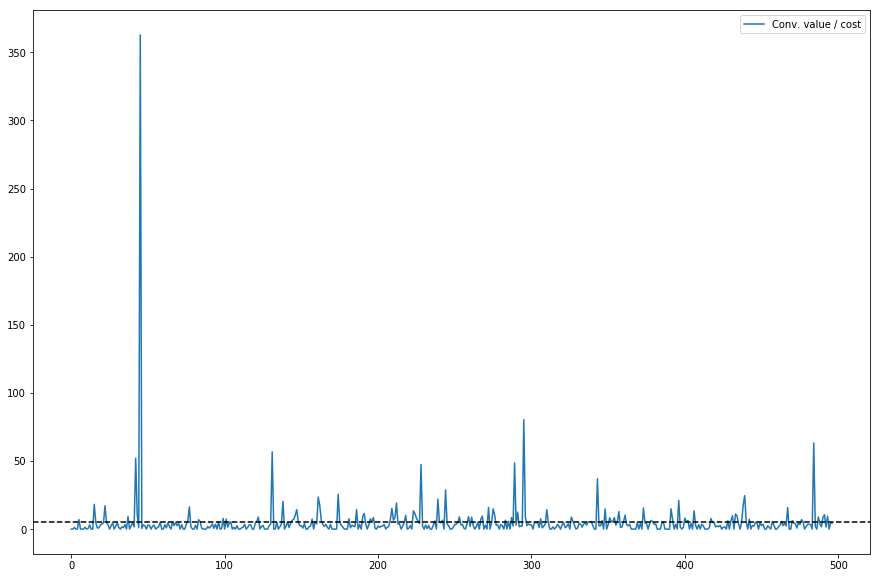

In [34]:
# This is the average revenue in $ per dollar spent on advertising.
# We should try to even out this graph, with ideally everything ~= 1 (thats for marginal though. Hmmmm)
# So press down the bumps with an increase in spending, and pull up the troughs by decreasing spending.

mobile[["Conv. value / cost"]].plot().axhline(y=mobile["Conv. value / cost"].describe().iloc[1], color='black', linestyle='--')

In [35]:
orig_mobile

,Location,Bid adj.,Clicks,Impr.,CTR,Avg. CPC,Cost,Avg. pos.,Conversions,Cost / conv.,Conv. rate,Conv. value,Conv. value / cost
0,"Fremont, Ohio, United States",+60%,72,"1,108",6.50%,$0.43,$30.82,2.6,0.00,$0.00,0.00%,0.00,0.00
1,"32216, Florida, United States",+45%,51,857,5.95%,$0.43,$22.04,2.6,0.00,$0.00,0.00%,0.00,0.00
2,"Madera, California, United States",+60%,186,"2,187",8.50%,$0.46,$85.09,2.6,2.00,$42.55,1.08%,103.30,1.21
3,"Linden, Alabama, United States",+60%,3,79,3.80%,$0.31,$0.93,3.0,0.00,$0.00,0.00%,0.00,0.00
4,"60632, Illinois, United States",-90%,8,263,3.04%,$0.02,$0.19,3.7,0.00,$0.00,0.00%,0.00,0.00
5,"Alexandria, Virginia, United States",+15%,351,"5,261",6.67%,$0.34,$118.89,2.9,6.00,$19.82,1.71%,829.98,6.98
6,"92024, California, United States",+36%,93,"1,247",7.46%,$0.42,$38.79,2.7,0.00,$0.00,0.00%,0.00,0.00
7,"Texas City, Texas, United States",+60%,142,"1,856",7.65%,$0.47,$66.69,2.6,0.00,$0.00,0.00%,0.00,0.00
8,"Pasco, Washington, United States",+60%,172,"2,337",7.36%,$0.44,$75.60,2.5,0.00,$0.00,0.00%,0.00,0.00
9,"Yuba City, California, United States",+60%,204,"2,771",7.36%,$0.43,$87.05,2.5,2.00,$42.96,0.99%,111.60,1.30


In [36]:
# TODO

#Split df into state and city/zip adjustments


In [39]:
# Examining State Level Bid Adjustments
# Plot - Conv. Value / Cost


state_adjustments = mobile[mobile.cityzip.isna()]
False(state_adjustments.state.isna()
# state_adjustments = state_adjustments.set_index('state')
# state_adjustments = state_adjustments.sort_values('Conv. value / cost')
# state_adjustments['Conv. value / cost'].plot.bar().axhline(y=state_adjustments["Conv. value / cost"].describe().iloc[1], color='black', linestyle='--')


15     False
16     False
19     False
21     False
48     False
66     False
68     False
69     False
75     False
96     False
104    False
120    False
130    False
137    False
141    False
143    False
175    False
188    False
195    False
197    False
206     True
214    False
217    False
223    False
225    False
227    False
246    False
252    False
265    False
280    False
298    False
299    False
304    False
306    False
317    False
321    False
339    False
353    False
374    False
377    False
380    False
386    False
419    False
421    False
435    False
440    False
444    False
447    False
450    False
463    False
474    False
480    False
495     True
496     True
Name: state, dtype: bool

In [23]:
# This gives us 2 issues to examine - wether we are underbidding at the tail (right),
# and/or overbidding at the head (left)

In [24]:
# Underbidding at right

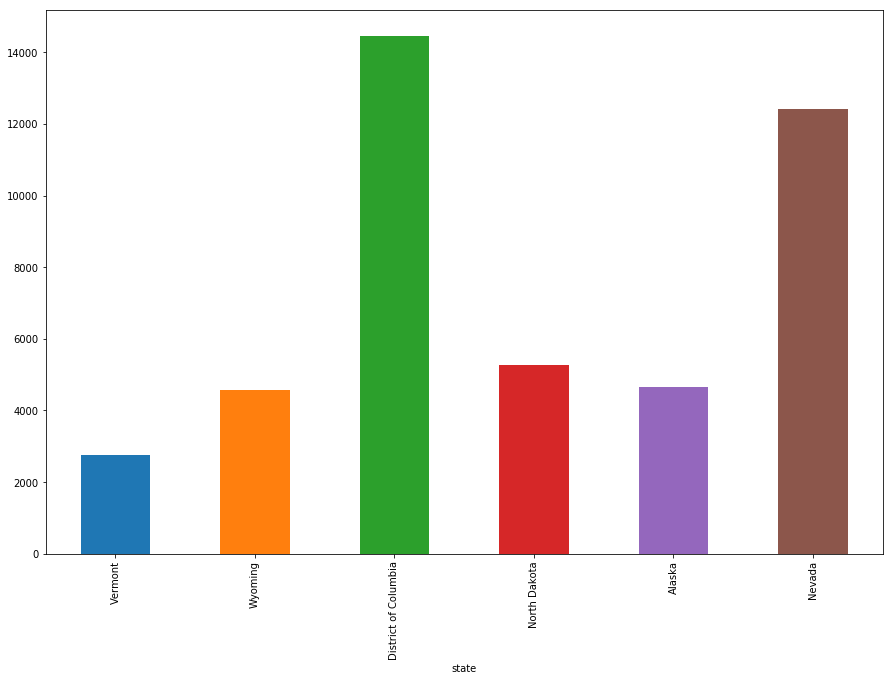

In [19]:
state_adjustments.tail(6)['Conv. value($)'].plot.bar()

In [21]:
state_adjustments.tail(6)

,Location,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost,cityzip
state,,,,,,,,,,,,,,
Vermont,"Vermont, United States",-15.0,1229.0,17899.0,6.87,0.30,364.60,3.0,28.0,13.02,2.28,2751.68,7.55,NaN
Wyoming,"Wyoming, United States",30.0,1653.0,22872.0,7.23,0.37,604.75,3.0,47.0,12.83,2.85,4563.33,7.57,NaN
District of Columbia,"District of Columbia, United States",45.0,4705.0,67808.0,6.94,0.38,1806.58,2.6,145.0,12.46,3.08,14450.32,8.00,NaN
North Dakota,"North Dakota, United States",0.0,1958.0,28348.0,6.91,0.32,620.38,3.0,47.0,13.20,2.40,5259.60,8.48,NaN
Alaska,"Alaska, United States",30.0,1041.0,14095.0,7.39,0.33,347.12,2.8,55.0,6.31,5.28,4656.91,13.42,NaN
Nevada,"Nevada, United States",0.0,2034.0,29739.0,6.84,0.34,683.25,2.8,115.0,5.94,5.66,12419.84,18.19,NaN


In [22]:
# In this graph, we're seeing only sales that came through state level BAs.
# Increase bids in NEVADA! 
# Also, given its relatively high Conv. Value, maybe a slight bump in DC maybe warranted as well.

In [25]:
state_adjustments.head()

,Location,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost,cityzip
state,,,,,,,,,,,,,,
NaN,United States,0.0,2649.0,54739.0,4.84,0.22,595.12,2.9,9.0,66.11,0.34,799.48,1.34,NaN
South Dakota,"South Dakota, United States",-15.0,1241.0,20665.0,6.01,0.25,316.30,3.1,8.0,39.54,0.64,711.99,2.25,NaN
South Carolina,"South Carolina, United States",15.0,10739.0,156711.0,6.85,0.32,3452.93,2.9,123.0,28.07,1.15,8333.30,2.41,NaN
Idaho,"Idaho, United States",-45.0,1768.0,29897.0,5.91,0.26,452.33,3.1,16.0,28.27,0.90,1104.88,2.44,NaN
Tennessee,"Tennessee, United States",15.0,13493.0,191569.0,7.04,0.33,4407.56,2.9,170.0,25.93,1.26,10956.40,2.49,NaN


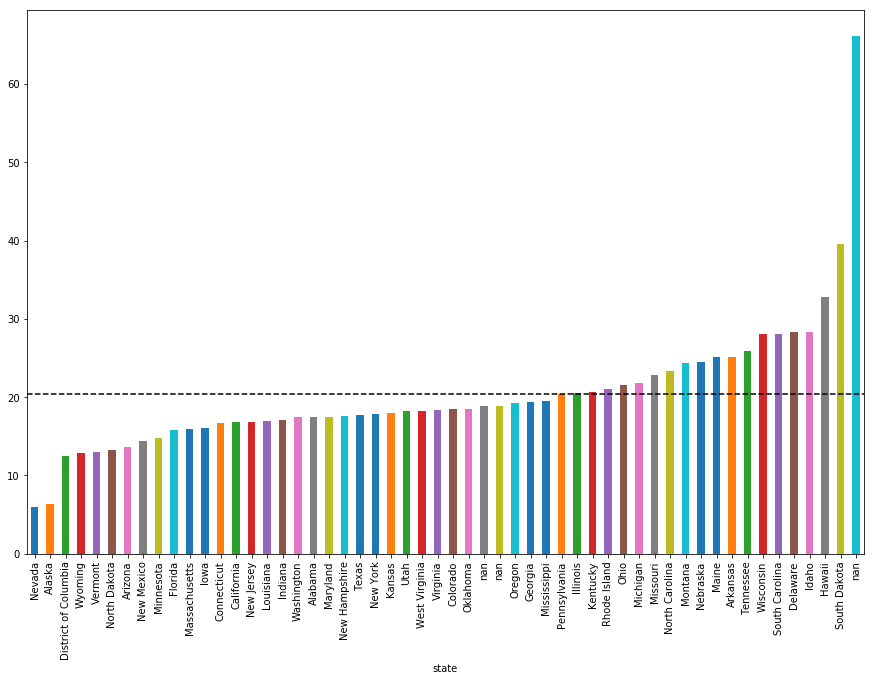

In [41]:
state_adjustments = state_adjustments.sort_values('cost_per_conv($)')
state_adjustments['cost_per_conv($)'].plot.bar().axhline(y=state_adjustments["cost_per_conv($)"].describe().iloc[1], color='black', linestyle='--')


In [42]:
# TODO ABOVE 

# WHERE THE HECK ARE THE NANS COMING From?

In [43]:
# TODO

# we can get average spend per coversion by taking ratio of conv.value and cost

In [9]:
# TODO

# Find a list of places where this graph is spiking, and graph against number of coversions
# We should try to figure out how many are unique conversions/ as opposed to a returning customers.


In [10]:
mobile[mobile["Conv. value / cost"]>3]

,Location,Bid adj.(%),Clicks,Impr.,CTR(%),avg_cpc($),Cost($),Avg. pos.,Conversions,cost_per_conv($),conversion_rate(%),Conv. value($),Conv. value / cost,state,cityzip
0,"Milwaukee, Wisconsin, United States",60.0,482.0,9312.0,5.18,0.67,324.67,2.5,21.0,15.46,4.36,1900.95,5.86,Wisconsin,Milwaukee
1,"Plant City, Florida, United States",30.0,57.0,632.0,9.02,0.69,39.38,2.7,5.0,7.88,8.77,491.92,12.49,Florida,Plant City
2,"North Carolina, United States",0.0,6205.0,102295.0,6.07,0.50,3076.82,2.8,131.0,23.49,2.11,11291.79,3.67,North Carolina,NaN
7,"San Jose, California, United States",30.0,892.0,17326.0,5.15,0.58,513.73,2.7,34.0,15.11,3.81,3989.49,7.77,California,San Jose
9,"Ellicott City, Maryland, United States",60.0,95.0,1622.0,5.86,0.74,69.84,2.5,1.0,69.84,1.05,210.04,3.01,Maryland,Ellicott City
10,"Conroe, Texas, United States",60.0,150.0,2192.0,6.84,0.70,104.90,2.6,4.0,26.23,2.67,798.86,7.62,Texas,Conroe
13,"Utah, United States",0.0,2663.0,38312.0,6.95,0.55,1462.09,2.5,69.0,20.93,2.62,7814.38,5.41,Utah,NaN
18,"Spring, Texas, United States",15.0,249.0,4146.0,6.01,0.54,133.79,2.8,7.0,19.11,2.81,672.82,5.03,Texas,Spring
22,"Salt Lake City, Utah, United States",0.0,377.0,6673.0,5.65,0.47,177.75,2.6,12.0,14.65,3.20,1239.55,7.05,Utah,Salt Lake City
23,"Killeen, Texas, United States",60.0,136.0,2094.0,6.49,0.78,105.82,2.5,3.0,35.20,2.22,624.36,5.91,Texas,Killeen


In [11]:
# TODO - See if there is a mismatch between adjustment and cost/conv. if there is a positive BA
# but low conversions OR high cost/conversion(?) we should revise downwards

In [12]:
# TODO - Separate state level bids and compare them to agregated bids by city per state. If there is a mismatch,
# Lets say we have a BA of +50% in the state but in the cities and zips we have -50, that doesn't make sense.

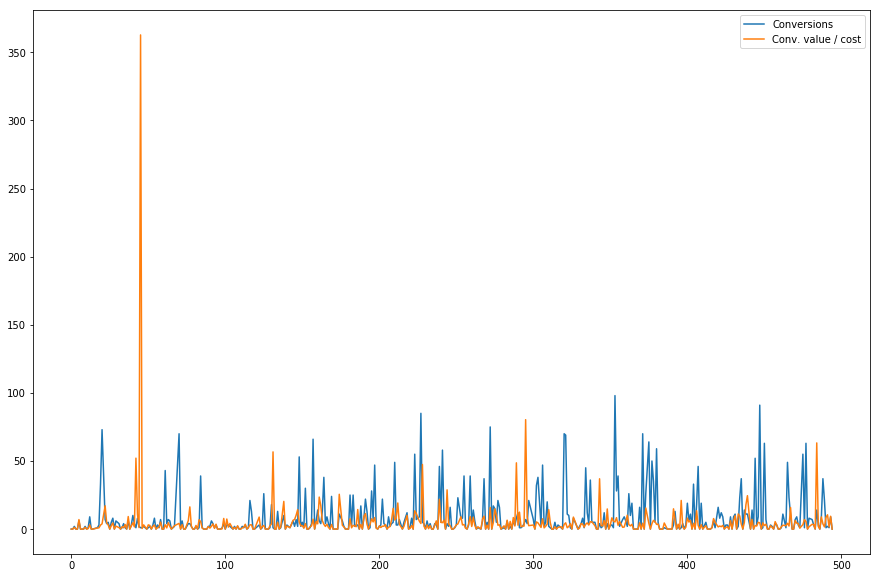

In [45]:
df2 = mobile[mobile['Conversions']<100]
df2[["Conversions","Conv. value / cost"]].plot()

In [14]:
# Sort this by column1
mobile["Conv. value / cost"].value_counts().head()

0.00    96
0.94     4
0.35     3
2.57     3
4.39     3
Name: Conv. value / cost, dtype: int64

In [15]:
# There are a number of records where no conversions happen, and some of them cost a lot of money
# We could turn down the BA on these.
# Is there anything we need to check against for this? 
# The conversion rate here is 0
# Total cost for these ads - once the cost is an int.

cost_where_no_conversion= 0


In [16]:
mobile["Conv. value / cost"].describe().iloc[1]

4.4492966360856272